In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [15]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd

## Dataset creation with hybrid model

In [5]:
attributes = ['title','authors','venue','year']

In [6]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_acm_hybrid.pth')

In [7]:
testneg_hybrid,testneg_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/',
                                                                         'test_negatives',
                                                           batch_size=128,model=hybrid_model,
                                                                         layer=hybrid_model.classifier,device=-1)

In [8]:
testpos_hybrid,testpos_ids = return_layer_input('../../Structured/DBLP-ACM/','test_positives',
                                                           batch_size=128,model=hybrid_model,
                                                layer=hybrid_model.classifier,
                                                          device=-1)

In [9]:
positives_hybrid,pos_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/','positives',
                                                           batch_size=128,model=hybrid_model,
                                              layer=hybrid_model.classifier,
                                                          device=-1)

In [10]:
negatives_hybrid,neg_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/','negatives',
                                                           batch_size=128,model=hybrid_model,
                                              layer=hybrid_model.classifier,
                                                          device=-1)

In [11]:
hybrid_model = hybrid_model.cuda()

In [13]:
## Basta scegliere un campione a caso
classifier_len = len(testneg_hybrid[0][0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery

### Negatives

In [16]:
neg_ri,neg_ri_norms = computeRi(hybrid_model.classifier,attributes,testneg_hybrid,attribute_len,
                               1)

100%|██████████| 109/109 [00:20<00:00,  5.19it/s]


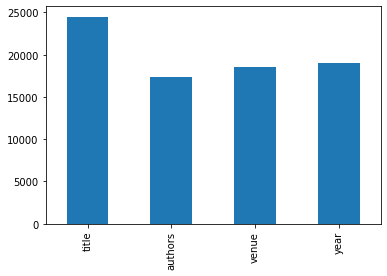

In [18]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum(numeric_only=True).plot.bar()

In [25]:
negatives_variation_df.to_csv('experiment_results/testneg_ri_hybrid.csv',index=False)

### Positives

In [21]:
pos_ri,pos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos_hybrid,attribute_len,
                               0)

100%|██████████| 60/60 [00:04<00:00, 12.40it/s]


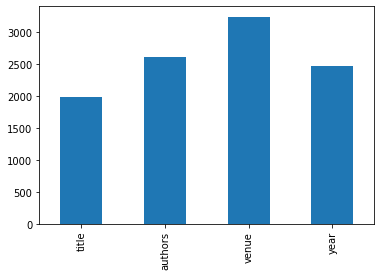

In [22]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [23]:
positives_variation_df.to_csv('experiment_results/testpos_ri_hybrid.csv',index=False)

## Nearest neighbors discovery

In [26]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [28]:
negatives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testneg_hybrid,testneg_ids_hybrid,
                                                                       neg_ri,positives_hybrid,pos_ids_hybrid,
                                                                      attributes,attribute_len,min_similarity=0.5)

100%|██████████| 109/109 [00:00<00:00, 361.16it/s]


In [30]:
negatives_closer_vectors_df.to_csv('experiment_results/testneg_nn_hybrid_withfilter.csv',index=False)

In [31]:
positives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testpos_hybrid,testpos_ids,pos_ri,
                                                                      negatives_hybrid,neg_ids_hybrid,
                                                                      attributes,attribute_len,min_similarity=0.5)

100%|██████████| 60/60 [00:00<00:00, 88.76it/s]


In [34]:
positives_closer_vectors_df.to_csv('experiment_results/testpos_nn_hybrid_withfilter.csv',index=False)